# Задание

##### Необходимо проанализировать данные и определить:
* реклама для каких групп является более эффективной
* нужно ли рекламодателю устанавливать таргетинги на отдельные группы пользователей (если да, то на какие)
* нужно ли рекламодателю ограничивать время показа рекламы

##### По результатам анализа сформулировать рекомендации для рекламодателя 

##### План к действию:
 * подготовить данные (почистить их и привести к удобному виду)
 * оценить зависимости в данных (визуально)
 * посчитать ctr для зависимых групп и сделать выводы/рекомендации
 * посчитать ctr для разного времени суток и сделать выводы/рекомендации

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
df = pd.read_csv('python_task_dataset.csv')
# выкинем те строки, где число известных значений не менее 8
df.dropna(thresh=8)
df = df.drop_duplicates().reset_index(drop=True)

In [85]:
df.head(3)

,device_id,device_type,datetime,ev_type,adv_type,region_id,age,gender
0,100001,android,2019-03-01 15:58:02,0,multi,2,14,2
1,100001,android,2019-03-01 17:13:53,0,multi,2,14,2
2,100002,android,2019-03-01 23:13:25,0,multi,2,0,0


In [86]:
df.shape # мы увидим информацию о размерности нашего датафрейма 

(265396, 8)

In [87]:
df.info() # покажет информацию о размерности данных 
          # описание индекса, количество not-a-number элементов 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265396 entries, 0 to 265395
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   device_id    265396 non-null  int64 
 1   device_type  265396 non-null  object
 2   datetime     265396 non-null  object
 3   ev_type      265396 non-null  int64 
 4   adv_type     265396 non-null  object
 5   region_id    265396 non-null  int64 
 6   age          265396 non-null  int64 
 7   gender       265396 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 16.2+ MB


In [88]:
df.describe() # показывает статистики count,mean, std, min, 25%-50%-75% percentile, max 

,device_id,ev_type,region_id,age,gender
count,265396.000000,265396.000000,265396.000000,265396.000000,265396.000000
mean,180685.468070,0.015479,1.204947,28.561787,0.932527
std,55776.139272,0.123447,0.403663,15.912835,0.376292
min,100001.000000,0.000000,1.000000,0.000000,0.000000
25%,130826.750000,0.000000,1.000000,21.000000,1.000000
50%,176487.500000,0.000000,1.000000,29.000000,1.000000
75%,228102.250000,0.000000,1.000000,38.000000,1.000000
max,287158.000000,1.000000,2.000000,75.000000,2.000000


In [89]:
df.nunique() # количество уникальных значений для каждого столбца

device_id      187158
device_type         2
datetime       193217
ev_type             2
adv_type            2
region_id           2
age                76
gender              3
dtype: int64

In [90]:
# приводим датафрейм к удобному виду
df['shows']  = [1 if x == 0 else 0 for x in df['ev_type']]
df['clicks'] = [1 if x == 1 else 0 for x in df['ev_type']]

df_for_device_analisys = df.copy(deep=True)

df['man'] = [1 if x == 2 else 0 for x in df['gender']]
df['woman'] = [1 if x == 1 else 0 for x in df['gender']]
df['unknown'] = [1 if x == 0 else 0 for x in df['gender']]

df['android'] = [1 if x == 'android' else 0 for x in df['device_type']]
df['ios'] = [1 if x == 'ios' else 0 for x in df['device_type']]


df['multi'] = [1 if x == 'multi' else 0 for x in df['adv_type']]
df['video'] = [1 if x == 'video' else 0 for x in df['adv_type']]

df['region_1'] = [1 if x == 1 else 0 for x in df['region_id']]
df['region_2'] = [1 if x == 2 else 0 for x in df['region_id']]

del df['ev_type']
del df['gender']
del df['device_type']
del df['adv_type']
del df['region_id']
del df['device_id']

In [91]:
#  исследуем на предмет выбросов
uniq_age = sorted(list(df['age'].unique()))

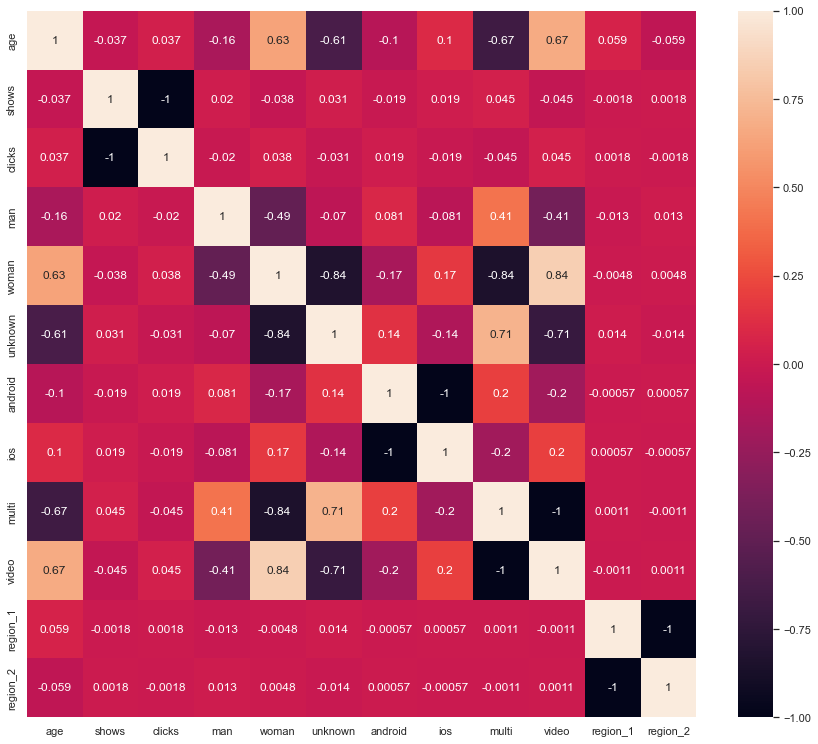

In [92]:
# находим корреляцию между значениями данных
plt.figure(figsize= (15,13))
sns.set(font_scale=1.0) 
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [97]:
names = ['age', 'shows','clicks', 'man', 'woman', 'unknown', 'android', 'ios','multi','video', 'region_1','region_2']
groups = []
for i in corr:
    for k, j in enumerate(corr[i]):
        # воспользуемся шкалой Чеддока и возьмем те зависимости, у которых характеристика силы связи от умеренной и выше (>=0.4)
        if j >= 0.4 and j != 1.0:
            pair = sorted([i, names[k]])
            if pair not in groups:
                groups.append(pair)

In [98]:
groups # наиболее зависимые группы

[['age', 'woman'],
 ['age', 'video'],
 ['man', 'multi'],
 ['video', 'woman'],
 ['multi', 'unknown']]

In [99]:
# посчитаем ctr не для каждого значения с каждым, а только для зависымых между собой значений
# коэффициент кликабельности может сильно отличаться в зависимости от ниши, сезона, объявления и тд

# каждую из групп посмотрим в разрезе возраста
groups = groups[2:]
res_ctr = []
groups

[['man', 'multi'], ['video', 'woman'], ['multi', 'unknown']]

Нам известно что в данных реклама двух типов: 
* 'multi' (мультиформат, вероятно, такая реклама используется для поисковых объявлений)
* 'video' (медийная реклама)

[Средний CTR в Google Ads (по всем отраслям):](https://www.wordstream.com/click-through-rate?roistat_visit=856969#:~:text=The%20average%20CTR%20in%20AdWords,%25%2B%20on%20the%20display%20network.)
* для поисковых объявлений — 1.91%;
* для медийной рекламы (КМС) — 0.35%.

Поэтому в результате отберем такие группы, у которых ctr >= 0.35, если adv_type == 'video', и ctr >= 1.91, если adv_type == 'multi', чтобы отобрать для какихз групп рк наиболее эффективна 

In [100]:
for g in groups:
    res = []
    for age in uniq_age:
        if len(g) == 1 :
            shows = df[(df['age']== age) & (df[g[0]]== 1) & (df['shows']== 1)].count()['shows']
            clicks = df[(df['age']== age) & (df[g[0]]== 1) & (df['clicks']== 1)].count()['clicks']
            ctr = 0 if shows == 0 else (clicks/ shows) * 100
            if ((ctr >= 0.35) and ('video' in g)) or ((ctr >= 1.91) and ( 'multi' in g)):
                res.append([age, g[0], ctr])
        else: 
            shows = df[(df['age']== age) & (df[g[0]]== 1) & (df[g[1]]== 1) & (df['shows']== 1)].count()['shows']
            clicks = df[(df['age']== age) & (df[g[0]]== 1) & (df[g[1]]== 1) & (df['clicks']== 1)].count()['clicks']
            ctr = 0 if shows == 0 else (clicks/ shows) * 100
            if ((ctr >= 0.35) and ('video' in g)) or ((ctr >= 1.91) and ( 'multi' in g)):
                res.append([age, g[0], g[1], ctr])
    if res != []:
        res_ctr.append(res)
res_ctr

[[[48, 'man', 'multi', 2.272727272727273],
  [53, 'man', 'multi', 6.25],
  [58, 'man', 'multi', 8.0],
  [61, 'man', 'multi', 5.0],
  [68, 'man', 'multi', 3.571428571428571]],
 [[14, 'video', 'woman', 1.371841155234657],
  [15, 'video', 'woman', 1.049204052098408],
  [16, 'video', 'woman', 1.5053763440860215],
  [17, 'video', 'woman', 0.8788449466415568],
  [18, 'video', 'woman', 1.942397856664434],
  [19, 'video', 'woman', 1.4948453608247423],
  [20, 'video', 'woman', 1.8808777429467085],
  [21, 'video', 'woman', 1.64771408679508],
  [22, 'video', 'woman', 2.1618122977346275],
  [23, 'video', 'woman', 2.1519659936238047],
  [24, 'video', 'woman', 1.9663252089956433],
  [25, 'video', 'woman', 1.8740239458615304],
  [26, 'video', 'woman', 1.8918198774313881],
  [27, 'video', 'woman', 2.034771410173857],
  [28, 'video', 'woman', 1.9186785260482846],
  [29, 'video', 'woman', 1.6848917652309754],
  [30, 'video', 'woman', 1.7579879378929808],
  [31, 'video', 'woman', 1.7258261933904526],
  [

### Реклама для каких групп является более эффективной

явно выделяется две группы: 
* мужчины возраста 48-68, которые смотрят рекламу типа "multi"
* женщины возраста 14-75, которые смотрят рекламу "video"

у женщин большой диапазон возраста, если посмотреть, где в среднем достигается наибольшое значение, то это группа с возрастом 46+

### Нужно ли рекламодателю устанавливать таргетинги на отдельные группы пользователей

Хорошо настроенный таргет, который работает на нужную аудиторию, это то, что нужно любой рекламной кампании, потому что, чем больше кликабельность, тем выше коэффициент конверсии.
Однако какой именно таргет устанавливать, на мой взгляд, заваисит от рекламы и от целей рекламодателя, а нам ничего не известно о том, какие именно ему нужны клиенты и что он рекламирует.

Может быть так, что аудитория, которая на данный момент отвечает на рекламу, не та, что нужна, тогда нужно менять рекламную компанию,
чтобы привлечь нужную аудиторию.

Предположим, что аудитория, которая откликнулась, та самая. Тогда нужно задаться вопросом как улучшить данный показатель. Можно настроить следющий таргет:
* для мужчин тип рекламы 'multi' и возраст аудитории 45+ (так как результаты анализа показывают, что заинтересованная аудитория у мужчин это аудитория в возрасте 48-68)
* для женщин тип рекламы 'video', но с возрастом сложнее. Так как нам неизвестно, какая именно нам нужна аудитория, а откликаются женщины всех возрастов, то я бы не стала настраивать таргет у женщин на возраст (до тех пор пока неизвестны цели рк)

In [101]:
df.head()

,datetime,age,shows,clicks,man,woman,unknown,android,ios,multi,video,region_1,region_2
0,2019-03-01 15:58:02,14,1,0,1,0,0,1,0,1,0,0,1
1,2019-03-01 17:13:53,14,1,0,1,0,0,1,0,1,0,0,1
2,2019-03-01 23:13:25,0,1,0,0,0,1,1,0,1,0,0,1
3,2019-03-01 23:25:06,0,1,0,0,0,1,1,0,1,0,0,1
4,2019-03-01 15:27:53,0,1,0,0,0,1,1,0,1,0,1,0


In [102]:
# для анализа рк по времени показа, удобно разделить данные по времени суток и по региону,
# так как регионы могут иметь разный часовой пояс

df['datetime'] = pd.to_datetime(df.datetime, format='%Y-%m-%d %H:%M:%S')
df['period'] = pd.cut(df.datetime.dt.hour, bins=[0, 6, 12, 18, 24], right=False,
    labels=['night', 'morning', 'afternoon', 'evening'])

res = []
for reg in ['region_1', 'region_2']:
    r = []
    df_r = df[df[reg] == 1].reset_index(drop=True)
    for p in ['night', 'morning', 'afternoon', 'evening']:
        df_r_p = df_r[df_r['period'] == p]
        r.append([reg+' '+p, df_r_p])
    res.append(r)

In [103]:
# считаем ctr для каждого региона и каждого времени дня и ночи
result_ctr_regions = []
for r in res:
    result_ctr = []
    for k in r:
        v = k[1]
        shows = v[v['shows']== 1].count()['shows']
        clicks = v[v['clicks']== 1].count()['clicks']
        ctr = 0 if shows == 0 else (clicks/ shows) * 100
        result_ctr.append({k[0]:ctr})
    result_ctr_regions.append(result_ctr)
result_ctr_regions

[[{'region_1 night': 1.3116600949545345},
  {'region_1 morning': 1.628734105722703},
  {'region_1 afternoon': 1.8501582835033417},
  {'region_1 evening': 1.0834869397113698}],
 [{'region_2 night': 1.2071869736103313},
  {'region_2 morning': 1.7230615557497817},
  {'region_2 afternoon': 1.6748548459133543},
  {'region_2 evening': 1.0685970355049983}]]

#### По результатам видно, что разницы от времени суток и региона никакой нет, так что я бы не рекомендовала как-то ограничивать время показа рк

### По имеющимся данным можно также проанализировать пользователей с уникальных девайсов
Можно заметить, что количество записей в датафрейме 265396, а уникальных device_id только 187158,
то есть 30% это девайсы, которым реклама показывается не один раз или которые кликнули на рекламное объявление не один раз

Давайте посмотрим как это выглядит для одной из наших эффективных групп. Рассмотрим женщин всех возрастов, которым была показана реклама типа 'video':

In [104]:
v = df_for_device_analisys[(df_for_device_analisys['gender'] == 1) & (df_for_device_analisys['adv_type'] == 'video')]
с = v['device_id'].value_counts()
с

100288    41
149193    24
149030    21
151119    19
149266    19
          ..
196761     1
137992     1
196759     1
137993     1
287158     1
Name: device_id, Length: 165087, dtype: int64

В результатах мы получили, сколько раз каждому из девайсов была показана реклама/ был сделан клик

Давайте посмотрим на девайс 100288:

In [105]:
v[v['device_id'] == 149193].reset_index(drop=True)

,device_id,device_type,datetime,ev_type,adv_type,region_id,age,gender,shows,clicks
0,149193,ios,2019-03-03 19:23:48,0,video,1,19,1,1,0
1,149193,ios,2019-03-05 16:56:42,0,video,1,19,1,1,0
2,149193,ios,2019-03-05 20:20:29,0,video,1,21,1,1,0
3,149193,ios,2019-03-06 13:47:11,0,video,1,19,1,1,0
4,149193,ios,2019-03-06 13:49:05,0,video,1,19,1,1,0
5,149193,ios,2019-03-05 17:19:14,0,video,1,19,1,1,0
6,149193,ios,2019-03-03 19:23:36,0,video,1,19,1,1,0
7,149193,ios,2019-03-04 01:47:11,0,video,1,19,1,1,0
8,149193,ios,2019-03-04 16:48:22,0,video,1,19,1,1,0
9,149193,ios,2019-03-04 16:48:26,0,video,1,19,1,1,0


во первых, можно сделать вывод, что одним устройством пользуется несколько человек
во вторых, было бы интересно посмотреть, после какого показа происходит ли клик и происходит ли вообще
для этого отберем только те устройства, которыми пользуется только один человек (то есть именно одному челочеку показывается реклама несколько раз)

результат - это массив с device_id, на котором реклама показывалась больше одного раза и смотрел ее один пользователь,ctr и количество показов/кликов для такой площадки, то есть теперь можно сделать вывод:
#### сколько раз нужно показать рекламу, чтобы на нее кликнули

напомню, что для рекламы типа 'video' мы смотрим на ctr >= 0.35%

тогда:

In [46]:
devices = []
ctrs = []
counts = []
for k, v in с.items():
    dff = df_for_device_analisys[df_for_device_analisys['device_id'] == k]
    if (len(dff['age'].unique()) == 1) & (v > 1):
        shows = dff[dff['shows']== 1].count()['shows']
        clicks = dff[dff['clicks']== 1].count()['clicks']
        ctr = 0 if shows == 0 else (clicks/ shows) * 100
        if ctr >= 0.35:
            devices.append(k)
            ctrs.append(ctr)
            counts.append(v)

давайте посмотрим для нашей группы:
* количество показов/кликов у максимального ctr
* среднее количество показов/кликов для ctr >= 0.35
* количество показов/кликов у медианного ctr

In [62]:
import statistics
print('количество показов/кликов у максимального ctr: ', counts[ctrs.index(max(ctrs))])
print('среднее количество показов/кликов для ctr >= 0.35: ', statistics.mean(counts))
print('количество показов/кликов у медианного ctr: ', counts[ctrs.index(statistics.median(ctrs))])

количество показов/кликов у максимального ctr:  3
среднее количество показов/кликов для ctr >= 0.35:  2.4664348756351964
количество показов/кликов у медианного ctr:  8


###### Таким образом, для группы "женщины всех возрастов, которым демонстрируется реклама типа 'video'" я бы рекомендовала одному и тому же пользователю (его можно определить по айди девайса и возрасту) показывать рекламу 3 раза, именно столько раз хватает, чтобы пользователь заинтересовался рк